In [23]:
%matplotlib inline
import time
import collections
import random

import tqdm.notebook
import numpy as np
import cv2
from matplotlib import pyplot as plt
import scipy.spatial

from drone_records import frames_at

tqdm = tqdm.notebook.tqdm

FILENAME = '/run/media/kubin/Common/deepsat/drone2.MP4'
SUB_FILENAME = '/run/media/kubin/Common/deepsat/drone2.SRT'
SUB_SEC_GAP = 1.0

In [3]:
def imshow(image):
    plt.imshow(image[:,:,::-1])
    return plt.show()

In [10]:
ind = tuple(range(3000, 3000+2*50, 50))
frames = frames_at(ind, FILENAME, SUB_FILENAME)

Video at fps=25.0


In [11]:
for frame in  frames:
    frame.image = frame.image[140:-140, 560:-560]

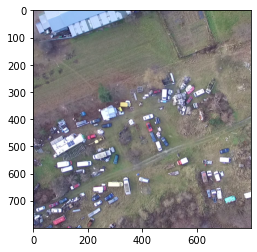

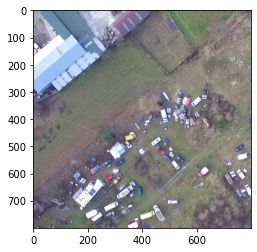

In [12]:
for j, frame in zip(ind, frames[:5]):
    imshow(frame.image)

In [13]:
# stitcher = cv2.Stitcher.create(1)
# stitcher.setPanoConfidenceThresh(0.3)
# st_start = time.time()
# status, out = stitcher.stitch([frame.image for frame in frames])
# st_end = time.time()
# print(f"Status is {status}, done in {st_end - st_start:.2f}s")

In [14]:
# print(out.shape)
# imshow(out)
# cv2.imwrite('sample.png', out)

In [26]:
def close_zero(image, p, k=5):
    x, y = int(p[0]), int(p[1])
    x1, x2 = max(0, x - k), min(image.shape[0]-1, x + k)
    y1, y2 = max(0, y - k), min(image.shape[1]-1, y + k)
    return np.all(image[x1:x2,y1:y2] == 0, axis=-1).any()
    
def homography_for_pair(image1, image2, *, lowe_filter_strength=0.7, bad_zeroes=True): # racism
    image1, image2 = image1.copy(), image2.copy()
    sift = cv2.SIFT.create()
    key1, desc1 = sift.detectAndCompute(image1, None)
    key2, desc2 = sift.detectAndCompute(image2, None)
    img = cv2.drawKeypoints(image1, key1, None, color=(0, 255, 0))
    imshow(img)
    cv2.imwrite('features.png', img)

    if bad_zeroes:
        key1 = [key for key in key1 if not close_zero(image1, key.pt)]
        key2 = [key for key in key2 if not close_zero(image2, key.pt)]
        
    
    matcher = cv2.FlannBasedMatcher({'algorithm': 1, 'trees': 10}, {'checks': 125})
    matches = matcher.knnMatch(desc2, desc1, k=2)
    matches = [m for m, n in matches if m.distance < 0.8*n.distance]
 
    img = cv2.drawMatches(image2, key2, image1, key1, random.sample(matches, 256), None, matchColor=(0,255,0), singlePointColor=None, flags=2)
    imshow(img)
    cv2.imwrite('matches.png', img)

    src = np.float32([key2[match.queryIdx].pt for match in matches]).reshape(-1, 1, 2)
    dst = np.float32([key1[match.trainIdx].pt for match in matches]).reshape(-1, 1, 2)
    print('RANSAC on ', len(src), '-', len(dst))
    H, mask = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
                    
    return H

2020-12-26 13:37:44 2020-12-26 13:37:46


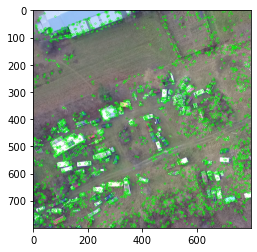

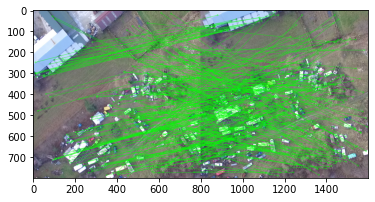

RANSAC on  1376 - 1376
[[ 9.49017507e-01 -3.32282075e-01  1.54559266e+02]
 [ 3.26795570e-01  9.51337242e-01 -2.14400440e+02]
 [ 4.79856631e-06 -3.82781218e-07  1.00000000e+00]]



In [27]:
n = 2
minX, maxX, minY, maxY = 0, 0, 0, 0
def shift_matrix():
    return np.array([
        [0, 0, -minX],
        [0, 0, -minY],
        [0, 0, 0]
    ])

Hs = []
M = np.identity(3)
for first, second in tqdm(zip(frames, frames[1:n]), total=n-1):
    print(first.datetime, second.datetime)
    image1, image2 = first.image, second.image
    H = homography_for_pair(image1, image2, lowe_filter_strength=0.8)
    print(H)
    Hs.append(H)
    M = M @ H
    
    w, h, _ = image1.shape
    proj_pt = np.float32(((0, 0), (0, w), (h, w), (h, 0))).reshape(-1, 1, 2)
    proj = np.int32(cv2.perspectiveTransform(proj_pt, M))
    x1, x2, y1, y2 = proj[:,:,0].min(), proj[:,:,0].max(), proj[:,:,1].min(), proj[:,:,1].max()
    minX, maxX, minY, maxY = min(x1, x2, minX), max(x1, x2, maxX), min(y1, y2, minY), max(y1, y2, maxY)
    # img = cv2.polylines(image2.copy(), [proj], True, 255, 3, cv2.LINE_AA)
    # imshow(img)
    # image = cv2.warpPerspective(image1, shift_matrix() + M, (maxX-minX+1, maxY-minY+1))
    # imshow(image)
Hs.append(np.identity(3))


(2542, 3192, 3)
sum
average
1e-09 0.07793862838670679 29776.788910088984


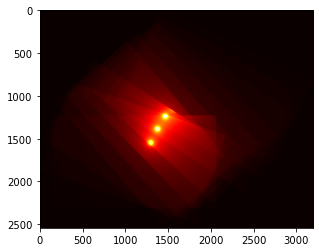

copy back to uint8
sum
average
1e-09 10.0 20958689.003023814


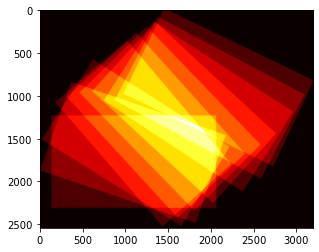

copy back to uint8


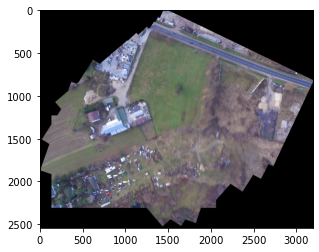

saving
done


In [40]:
M = np.identity(3)
images = [frame.image.copy() for frame in frames[:n]]
centers = []
for i in tqdm(range(n)):
    images[i] = cv2.warpPerspective(images[i], shift_matrix() + M, (maxX-minX+1, maxY-minY+1))
    cen = (shift_matrix() + M) @ [h/2, w/2, 1]
    centers.append((float(cen[0]), float(cen[1])))
    M = M @ Hs[i]
print(images[0].shape)

def weighted_average(images, mask):
    print("sum")
    out = sum(image.astype(np.float32)/255 * mask(i)[:,:,np.newaxis] for i, image in enumerate(images))
    print("average")
    smask = sum(mask(i) for i in range(len(images))).clip(min=1e-9) 
    print(smask.min(), smask.max(), smask.sum())
    plt.imshow(smask, cmap='hot'); plt.savefig('smask.png'); plt.show()
    out /= smask[:,:,np.newaxis]
    print("copy back to uint8")
    out = (out * 255).astype(np.uint8)
    return out

def occ_mask(i, images):
    m = np.all(images[i] != 0, axis=-1).astype(np.uint8)
    m &= np.pad(m, ((0, 0), (1, 0)), mode='constant')[:, :-1]
    m &= np.pad(m, ((0, 0), (0, 1)), mode='constant')[:, +1:] 
    m &= np.pad(m, ((1, 0), (0, 0)), mode='constant')[:-1, :]
    m &= np.pad(m, ((0, 1), (0, 0)), mode='constant')[+1:, :]
    return m
    
def occ_weighted_average(images):
    return weighted_average(images, lambda i: occ_mask(i, images))
    
def distance_mask(i, images, centers):
    arr = np.array(np.meshgrid(np.arange(images[i].shape[1]), np.arange(images[i].shape[0])))
    arr = np.moveaxis(arr, 0, -1)
    arr[:,:,(0,1)] = arr[:,:,(1,0)]
    arr = arr.reshape(-1, 2)
    return scipy.spatial.distance.cdist(arr, np.atleast_2d(centers[i])) \
            .ravel().reshape(*images[i].shape[:-1]).clip(min=20)**-1 * occ_mask(i, images)

def distance_weighted_average(images, centers):
    return weighted_average(images, lambda i: distance_mask(i, images, centers))
    
out = distance_weighted_average(images, centers)    
out1 = occ_weighted_average(images)

imshow(out)
print("saving")
cv2.imwrite('sample.png', out)
cv2.imwrite('sample_occ.png', out1)
print("done")

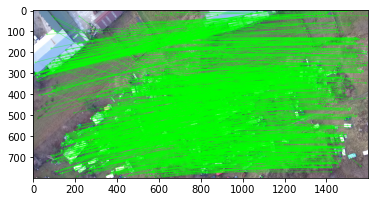

RANSAC on  1373 - 1373
(800, 800, 3) (800, 800, 3)
(1022, 1018, 3)


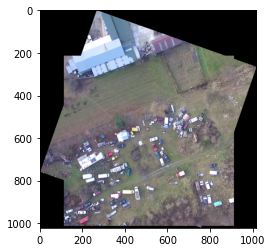

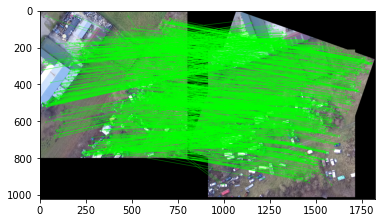

RANSAC on  1174 - 1174
(1022, 1018, 3) (800, 800, 3)
(1175, 1104, 3)


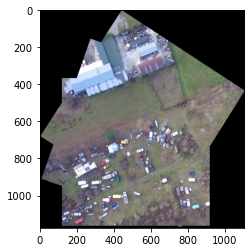

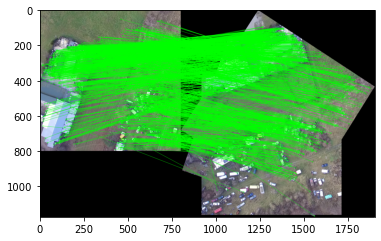

RANSAC on  1190 - 1190
(1175, 1104, 3) (800, 800, 3)
(1291, 1200, 3)


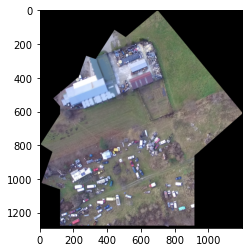

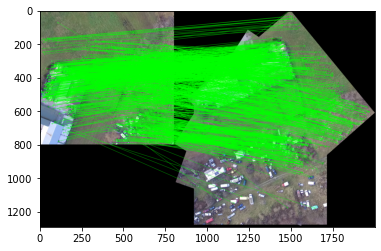

RANSAC on  1187 - 1187
(1291, 1200, 3) (800, 800, 3)
(1385, 1344, 3)


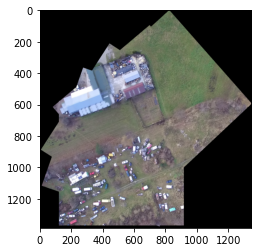

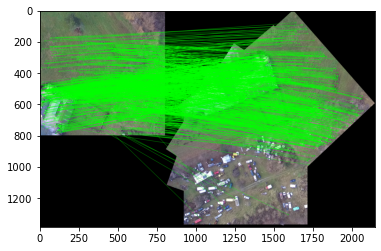

RANSAC on  979 - 979
(1385, 1344, 3) (800, 800, 3)
(1466, 1503, 3)


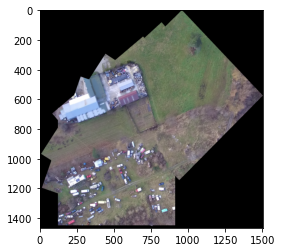

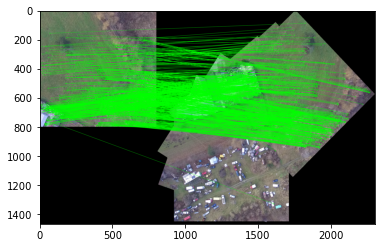

RANSAC on  763 - 763
(1466, 1503, 3) (800, 800, 3)
(1543, 1662, 3)


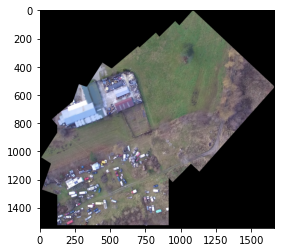

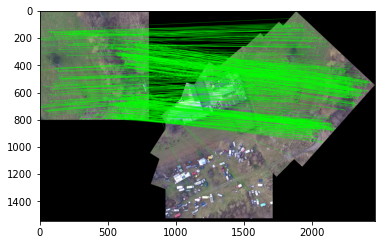

RANSAC on  550 - 550
(1543, 1662, 3) (800, 800, 3)
(1612, 1809, 3)


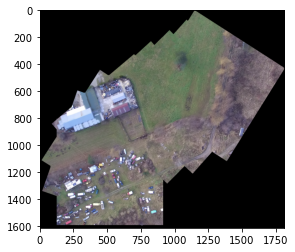

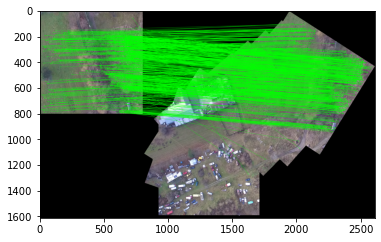

RANSAC on  742 - 742
(1612, 1809, 3) (800, 800, 3)
(1706, 1926, 3)


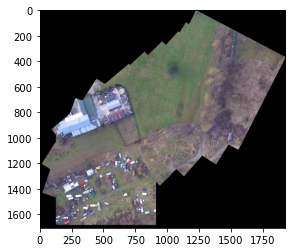

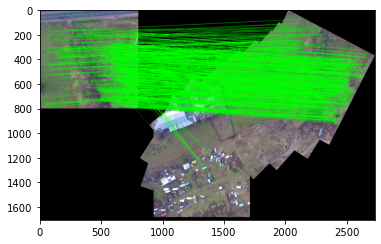

RANSAC on  972 - 972
(1706, 1926, 3) (800, 800, 3)
(1820, 2029, 3)


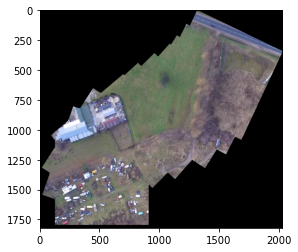

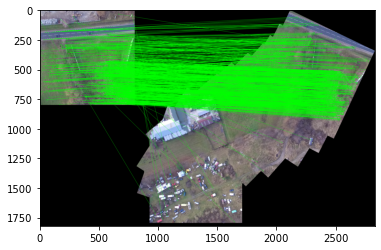

RANSAC on  903 - 903
(1820, 2029, 3) (800, 800, 3)
(1954, 2137, 3)


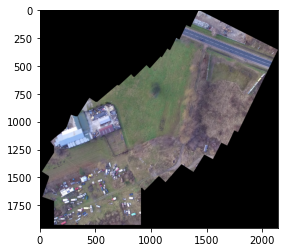

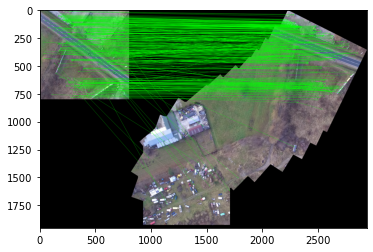

RANSAC on  400 - 400
(1954, 2137, 3) (800, 800, 3)
(2072, 2184, 3)


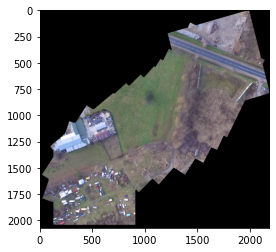

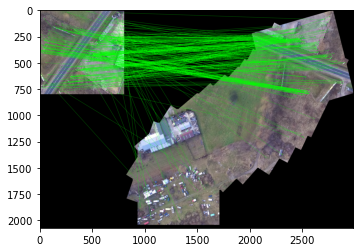

RANSAC on  308 - 308
(2072, 2184, 3) (800, 800, 3)
(2195, 2185, 3)


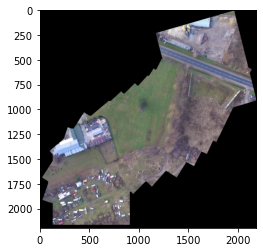

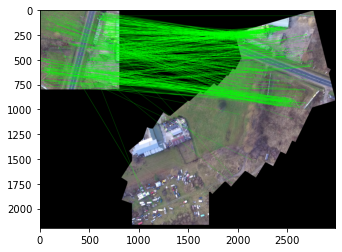

RANSAC on  504 - 504
(2195, 2185, 3) (800, 800, 3)
(2196, 2186, 3)


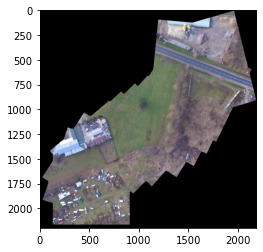

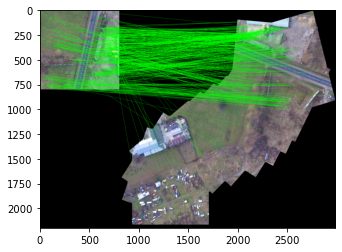

RANSAC on  496 - 496
(2196, 2186, 3) (800, 800, 3)
(2197, 2187, 3)


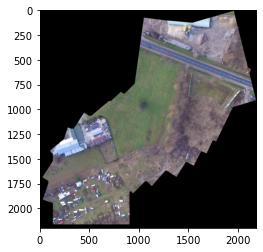

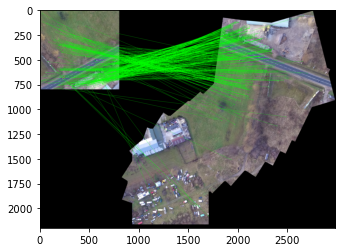

RANSAC on  321 - 321
(2197, 2187, 3) (800, 800, 3)
(2198, 2188, 3)


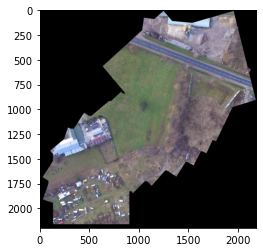

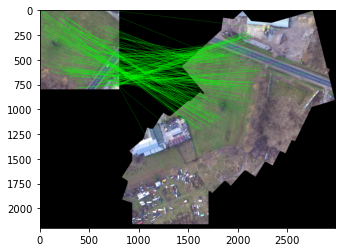

RANSAC on  251 - 251
(2198, 2188, 3) (800, 800, 3)
(2199, 2189, 3)


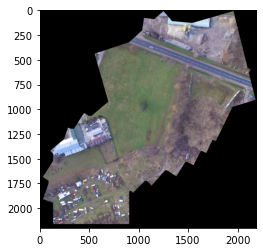

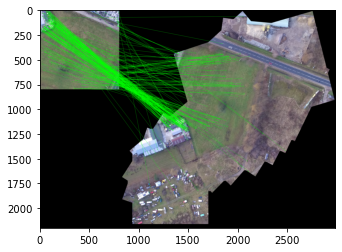

RANSAC on  253 - 253
(2199, 2189, 3) (800, 800, 3)
(2200, 2190, 3)


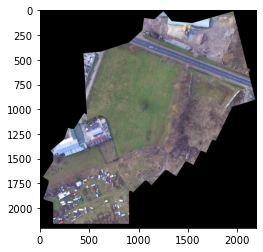

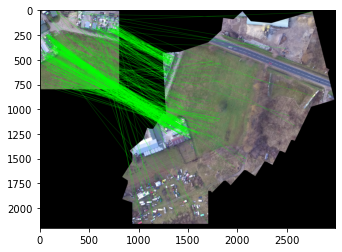

RANSAC on  483 - 483
(2200, 2190, 3) (800, 800, 3)
(2201, 2191, 3)


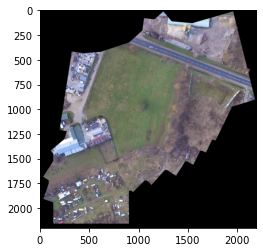

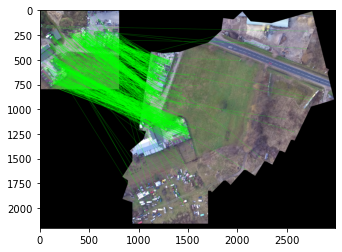

RANSAC on  859 - 859
(2201, 2191, 3) (800, 800, 3)
(2202, 2242, 3)


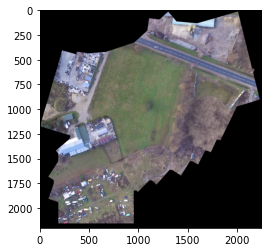

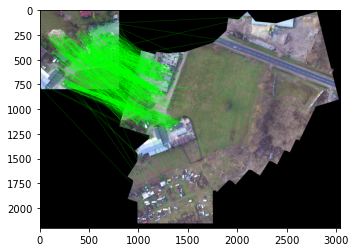

RANSAC on  1102 - 1102
(2202, 2242, 3) (800, 800, 3)
(2203, 2483, 3)


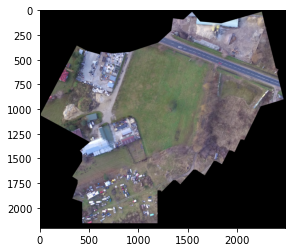

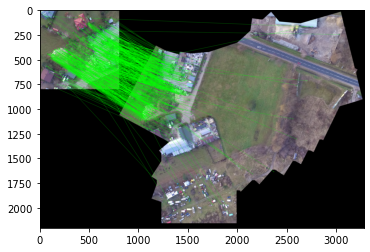

RANSAC on  715 - 715
(2203, 2483, 3) (800, 800, 3)
(2204, 2637, 3)


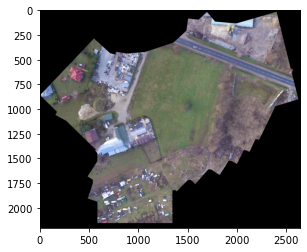

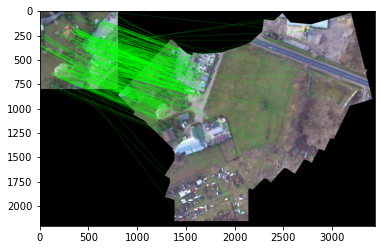

RANSAC on  694 - 694
(2204, 2637, 3) (800, 800, 3)
(2205, 2638, 3)


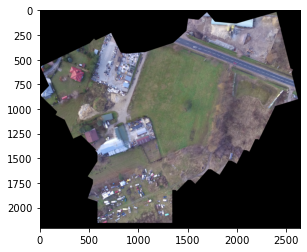

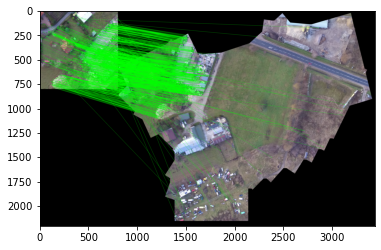

RANSAC on  1019 - 1019
(2205, 2638, 3) (800, 800, 3)
(2206, 2661, 3)


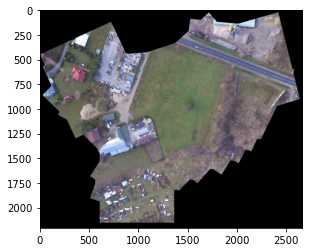

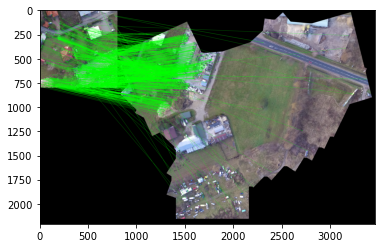

RANSAC on  963 - 963
(2206, 2661, 3) (800, 800, 3)
(2237, 2783, 3)


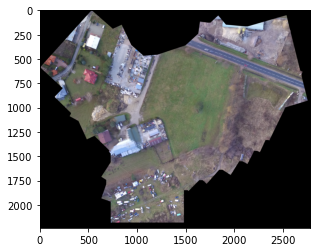

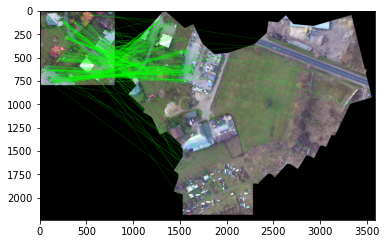

RANSAC on  424 - 424
(2237, 2783, 3) (800, 800, 3)
(2260, 2889, 3)


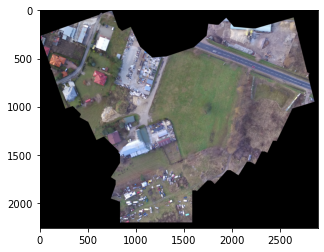

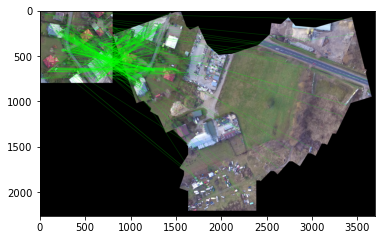

RANSAC on  414 - 414
(2260, 2889, 3) (800, 800, 3)
(2261, 3107, 3)


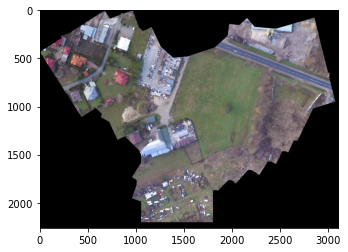

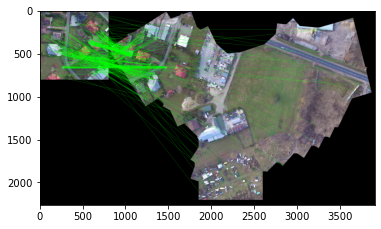

RANSAC on  445 - 445
(2261, 3107, 3) (800, 800, 3)
(2262, 3269, 3)


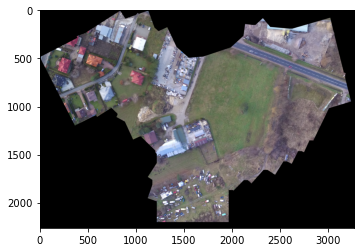

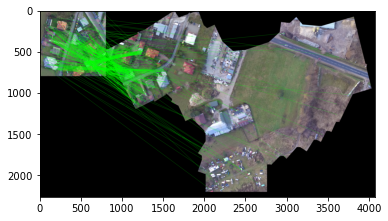

RANSAC on  469 - 469
(2262, 3269, 3) (800, 800, 3)
(2263, 3494, 3)


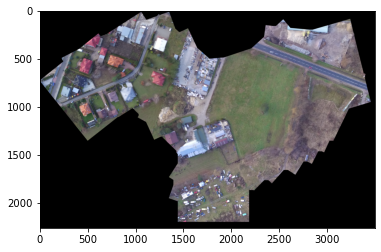

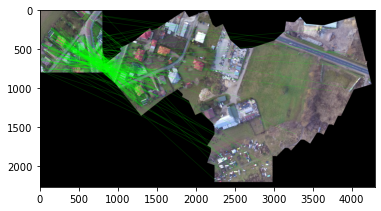

RANSAC on  391 - 391
(2263, 3494, 3) (800, 800, 3)
(2264, 3678, 3)


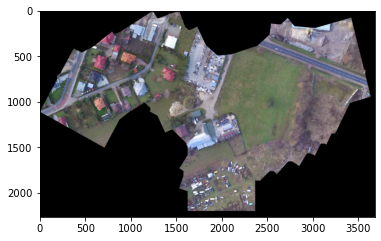

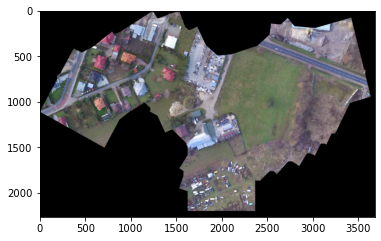

True

In [8]:
import importlib
import stitchin_test as stitchin
stitchin.imshow = imshow
out2 = stitchin.succ_stitch([frames[i].image.clip(min=1) for i in range(30)])
imshow(out2)
cv2.imwrite('sample_succ.png', out2)

In [10]:
for i in range(30):
    cv2.imwrite(f'frame{i}.jpg', frames[i].image)